# Data Analysis and Muon Lifetime

In this notebook we will discuss histograms, statistics, curve fitting, and analyzing simulated data from the muon lifetime experiment.



**First things first, make sure you save this notebook to your drive so you can save your changes!!!**

<div>
<img src="save_to_drive.png" width="250"/>
</div>

In [ ]:
# import libraries needed.  Run this block of code without modification.

%matplotlib notebook
%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import inspect

### Exercise 1: Define a gaussian distribution

The equation for a gaussian distribution is:

$$ \Large f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

Where $\mu$ is the mean and $\sigma$ is the width.  Define a python function called `gaussian` which accepts 3 arguments: `x`, `sigma` and `mean`.  The default value for `sigma` shoud be `1.0` and for mean `0.0`. 

You will need `np.sqrt`, `np.exp`, `np.power`, `np.pi` for square roots, exponentials, raising a number to a power, and using $\pi$.  Note that `np.pi` is a *member*, not a *function*, so you do not need the parentheses `()` when using `np.pi`.

In [124]:
def gaussian(x, sigma=1.0, mean=0.0):
    return 1.0/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*np.power((x-mean)/sigma,2))

Plot your gaussian function by defining an array of points using `np.linspace`.  Then use `plt.plot` to plot that array and the gaussian function.  Make sure that when you change `sigma` and `mean` you get the expected result.

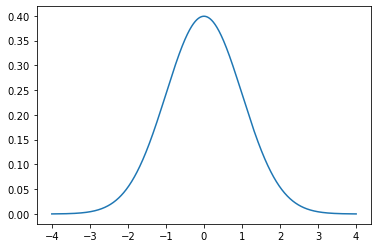

In [125]:
x = np.linspace(-4,4,1000)
plt.plot(x, gaussian(x))

### Exercise 2: Define a Laplace distribution

A gaussian is not the only distribution which has a mean and width.  In fact, you may find the functional form of a gaussian distribution strange.  Why is $x$ squared in the exponent, for example?  Why is $\pi$ there, and why is it the square root of $\pi$?  We can also define the Laplace, or "double exponential" distribution, where just the absolute value of $x$ is in the exponent, not $x^2$:

$$ \Large f(x)=\frac{1}{\sqrt{2}\sigma}e^{\left(\frac{-\sqrt{2}|x-\mu|}{\sigma}\right)}$$

Define the Laplace distribution below.  Use the function `np.abs` to compute the absolute value.

In [126]:
def laplace(x, sigma=1.0, mean=0.0):
    return 1.0/np.sqrt(2)/sigma*np.exp(-np.sqrt(2)*np.abs(x-mean)/sigma)

Similarly to the gaussian distribution, plot the triangular distribution and verify that changing the `sigma` and `mean` make sense.  Try plotting them both together with the same value of `sigma` and `mean`.

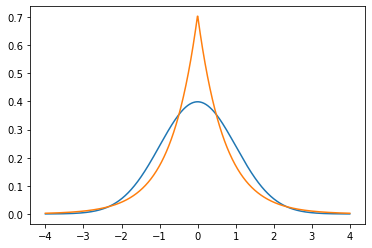

In [127]:
plt.plot(x, gaussian(x))
plt.plot(x, laplace(x))

The distributions have some similarities and some differences!  They appear to have nearly the same "width" when we set the value of `sigma` to be the same for both distributions.  However, the Laplace distribution is pointy and has more probability "mass" concentrated near the center while the gaussian distribution is smooth and more spread out.  Later in this notebook we will explore fitting a set of observed data to both distributions and seeing which one fits the data better.

### Exercise 3: Normalization of Probability Density Functions

One property of a **Probability Density Function** or PDF is that its integral is exactly 1.  You can think of this as adding up all the individual probabilities of every possible outcome and getting 100%.  Verify that the integral of these distributions is 1 regardless of the choice of `mean` and `sigma`.  To perform this integral numerically, perform the following steps:


1. Create a linearly spaced set of points `x` using `np.linspace`
2. Call the function, either `gaussian(x)` or `laplace(x)` over the linearly spaced set of points.
3. Use the built-in function `sum` to add together all of the values.
4. Multiply by d$x$: the spacing between points.  You can find it by typing: `dx=x[1]-x[0]`
5. Try several different values for `sigma` and `mean`.  Make sure that if you change them you also appropriately change the range.  The range should be at least from `mean-4*sigma` to `mean+4*sigma`.
6. Optional challenge: write a new function which numerically integrates a user provided function over the bounds `a` to `b` using the "algorithm" defined here.  Now, you can easily reuse your function to integrate several PDFs.


In [129]:
print(sum(gaussian(x)*(x[1]-x[0])))
print(sum(laplace(x)*(x[1]-x[0])))

0.9999377235083828
0.9965209113304567


### Fitting Histograms

The code below defines a function `plot_data_and_fit` which accepts a list or numpy array of observed data and creates a histogram and fits it to a function of your choice.

Read the code and try to understand the algorithm even if you don't understand each individual line of code.  Then, run the block of code with no modification.

In [130]:
#
# DO NOT MODIFY THIS CODE BLOCK

# define a style dictionary for data-like plotting
data_style={'color':'k', 'marker':"o", 'linestyle':'None', 'label':'Observed Data'}

'''
The method to plot a histogram and fit it to an arbitrary function.

Arguments:
 - observed data: array-like object containing all of the individual observations
 - num_bins:      number of bins for the histogram.  Default=10
 - function:      callable object representing the function we will fit to the data.
                  Default= the gaussian function you defined earlier.
 - guess:         Initial guess of parameter values.  If no guess is provided then it is initialized to 1 for
                  each parameter
'''
def plot_data_and_fit(observed_data, num_bins=10, function=gaussian, guess=[], doPlot=True):
    # get information about the fitting function.  The independent variable name, fit parameters, function name
    x_axis_name   = inspect.getfullargspec(function).args[0]
    callable_args = inspect.getfullargspec(function).args[1:]
    callable_name = [i for i, j in globals().items() if j is function][0]
    if isinstance(guess, float):
        guess = [guess]
    if len(guess) != len(callable_args):
        guess = [1.0]*len(callable_args) # list concatenation!

    # create a histogram and compute the error on each observation
    observed_counts, bin_edges = np.histogram(observed_data, bins=num_bins)
    bin_width   = (bin_edges[1:] - bin_edges[:-1])[0]
    bin_centers = bin_width/2 + bin_edges[:-1]
    observed_errors = np.sqrt(observed_counts)

    # define the chi-square test statistic.  Integrates the input function.  Automatically normalizes to N observations.
    def test_statistic(x):
        expected_counts = np.asarray([integrate.quad(function, a, b, args=tuple(x))[0] for a, b in zip(bin_edges[:-1], bin_edges[1:])])
        return stats.chisquare(observed_counts, expected_counts*sum(observed_counts)/sum(expected_counts), ddof=len(x)).statistic

    # minimize the chi square test statistic.  Get the best fit parameters.
    optimizedResult = opt.minimize(test_statistic, x0=guess)
    optimizedParameters = optimizedResult.x

    # use the hessian matrix and residual error to estimate the error bars on the best fit parameters.
    fitted_errors = np.sqrt( np.diag( optimizedResult.hess_inv * optimizedResult.fun))

    # print important information to the screen
    probability = 1-stats.chi2.cdf(optimizedResult.fun, float(len(bin_centers)-len(guess)))
    if doPlot:
        print("Chi square: ", optimizedResult.fun)
        print("N dof: ", len(bin_centers)-len(guess))
        print("Chi square Probability: ", probability)

        for i in range(len(optimizedParameters)):
            print(callable_args[i], ":", optimizedParameters[i], "+/-", fitted_errors[i])

        # Plot the histogram of the observed data
        plt.errorbar(bin_centers, observed_counts, yerr=observed_errors, **data_style)

        # Plot the fitted function
        x = np.linspace(min(observed_data), max(observed_data), 100)
        plt.plot(x, len(observed_data)*bin_width*function(x, *optimizedParameters), 'r', label=callable_name + ' Fit')

        # beautify plot
        plt.xscale('linear')
        plt.yscale('linear')
        plt.xlabel(x_axis_name)
        plt.ylabel('Entries')
        plt.title('Histogram and ' + callable_name + ' Fit')
        plt.legend()
        plt.show()
    
    # return output
    output = {'prob': probability, 
              'chi-sq': optimizedResult.fun,
              'NDF': len(bin_centers)-len(guess)
               }
    for i in range(len(callable_args)):
        output[callable_args[i]] = (optimizedParameters[i], fitted_errors[i])
    return output


### Exercise 4: Fit gaussian data

Generate some gaussian data with the function `np.random.normal(size=<N>)` where you can choose the number of points `<N>`.  Then, call the `plot_data_and_fit` function with your generated data.  By default it will use the gaussian function to fit this data.  You may want to define a reasonable value for the number of bins.  I suggest 1000 data points and 30 bins to start.

Chi square:  23.72934692300029
N dof:  28
Chi square Probability:  0.6957379282422048
sigma : 1.0628679367039549 +/- 0.09661252541517525
mean : -0.04634091330657488 +/- 0.11798638552745766


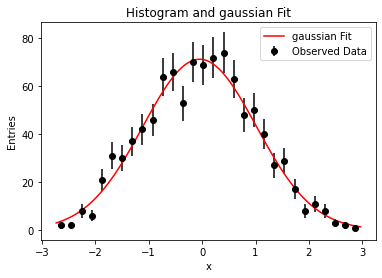

{'prob': 0.6957379282422048,
 'chi-sq': 23.72934692300029,
 'NDF': 28,
 'sigma': (1.0628679367039549, 0.09661252541517525),
 'mean': (-0.04634091330657488, 0.11798638552745766)}

In [133]:
plot_data_and_fit(np.random.normal(size=1000), num_bins=30)

You should see a set of black data points with error bars representing the range of values that might be observed if you repeated the experiment.  The red curve is the best-fit gaussian.  It also prints out the best fit value of the `sigma` and `mean`, with errors.  Next, try fitting the same data with the `laplace` function.  Compare the probability printout.  Is it more likely that the `gaussian` or `laplace` distribution describes this data?

Chi square:  72.48309892592209
N dof:  28
Chi square Probability:  8.310581911863402e-06
sigma : 1.2737128227126218 +/- 0.33824709269789766
mean : -0.05730114755065294 +/- 0.20436507351803343


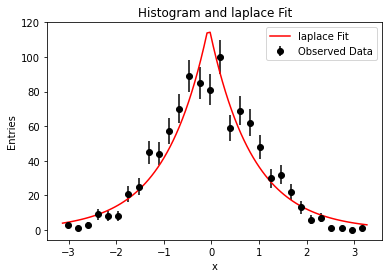

{'prob': 8.310581911863402e-06,
 'chi-sq': 72.48309892592209,
 'NDF': 28,
 'sigma': (1.2737128227126218, 0.33824709269789766),
 'mean': (-0.05730114755065294, 0.20436507351803343)}

In [134]:
plot_data_and_fit(np.random.normal(size=1000), num_bins=30, function=laplace)

Many processes in nature are described by guassian distributions (It is the "central limit" and "maximum entropy" probability distribution. If you are curious what this means check out 3Blue1Brown's videos about gaussians on YouTube).

### Exercise 5: Goodness of Fit and $\chi^2$ Probability

If we pick the **right** probability distribution then as we collect more data the value of the $\chi^2$ probability should be more or less unchanged.  If we pick the **wrong** probability distribution to fit the data then as we collect more data it should become more and more clear that we made the wrong choice.  Therefore, the $\chi^2$ probability should increase as we collect more data.  Write a `for` loop which on each iteration:

1. Creates a new set of gaussian data with the `size` parameter increasing.  The suggested sizes are already defined for you.
2. Fits the data to both a `gaussian` and a `laplace` distribution.  Save the dictionary returned by each call to `plot_data_and_fit`.  Use the `doPlot=False` argument in `plot_data_and_fit` so that it doesn't try to plot each individual fit.
3. Use the list `append` method to add each successive probability to the `gaus_probs` and `lapl_probs` lists.  You can access the probability in the returned dictionary like `dict["prob"]`.

After your `for` loop you will use `plt.plot` to plot `gaus_probs` and `lapl_probs` as a function of `sizes`.  You will also need to use `plt.xscale('log')` and `plt.yscale('log')` to make the axes have a logarithmic scale.  Try reading the above code that defines `plot_data_and_fit` to set the axis labels and make a legend for your plot.

Sometimes, depending on the generated data, the `plot_data_and_fit` function will complain and produce an error.  You can ignore this.

Text(0, 0.5, 'Probability')

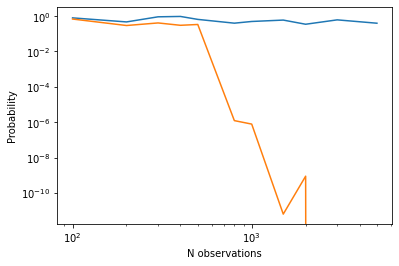

In [135]:
sizes = [100, 200, 300, 400, 500, 800, 1000, 1500, 2000, 3000, 5000]
gaus_probs = []
lapl_probs = []

for s in sizes:
    local_data = np.random.normal(size=s)
    gaus_dict = plot_data_and_fit(local_data, num_bins=30, doPlot=False)
    lapl_dict = plot_data_and_fit(local_data, num_bins=30, doPlot=False, function=laplace)
    gaus_probs.append(gaus_dict["prob"])
    lapl_probs.append(lapl_dict["prob"])
    
plt.plot(sizes, gaus_probs, label='Gaussian')
plt.plot(sizes, lapl_probs, label='Laplace')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N observations')
plt.ylabel('Probability')

About how many data points do we need to start to tell the difference between data distributed like a gaussian or a laplace distribution?

In particle physics we define "discovery" as a probability less than $3\times10^{-7}$.  How many observations would you need to "discover" that this data is not distributed like a laplace distribution?

### Exercise 6: Muon Lifetime

Now that we understand how to fit data and digest the results, we can try to fit the data from our muon lifetime experiment.

The muon decays to an electron and two neutrinos.  Particles that decay should be distributed according to an exponential distribution

$$\Large f(t)=\frac{1}{\tau}e^{-t/\tau}$$

Where $t$ is the measured time and $\tau$ is the lifetime of the muon.


Because the function `plot_data_and_fit` will default to guess a value of `1.0` for each parameter, we should initialize the guess to something reasonable or else the fit won't converge to the correct value.  The recommended guess for the muon lifetime is `guess=2e-6`.

Chi square:  29.218255625904398
N dof:  29
Chi square Probability:  0.4537428191933657
tau : 2.437131339728363e-06 +/- 0.00061213790279851


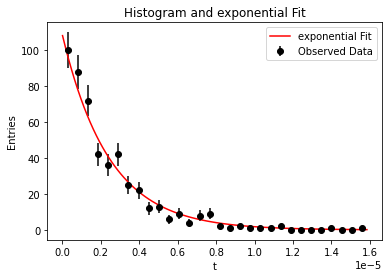

{'prob': 0.4537428191933657,
 'chi-sq': 29.218255625904398,
 'NDF': 29,
 'tau': (2.437131339728363e-06, 0.00061213790279851)}

In [141]:
def exponential(t, tau):
    return 1/tau * np.exp(-t / tau)

def simulate_muon_lifetime(n_muons):
    muon_lifetime = 2.2e-6
    return np.random.exponential(scale=muon_lifetime, size=n_muons)

plot_data_and_fit(simulate_muon_lifetime(500), num_bins=30, function=exponential, guess=[1e-6])

Repeat the experiment with more and more data.  A suggested progression is a set of logarithmically spaced points from 100 to 100000.  You can also try to make a similar plot to the one you made above for the probability changing as a function of the number of data points. This time, see how the best fit value of `tau` changes as you increase the statistics of the data sample.  You can access the best fit value of tau as `dict["tau"][0]`.

Try plotting the error on tau: `dict["tau"][1]`.  How does the best fit error change as we collect more data?

Text(0, 0.5, 'Best fit lifetime')

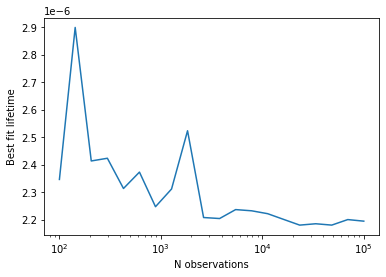

In [137]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = simulate_muon_lifetime(s)
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential, guess=2e-6)
    exp_probs.append(exp_dict["tau"][0])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit lifetime')

Text(0, 0.5, 'Best fit error')

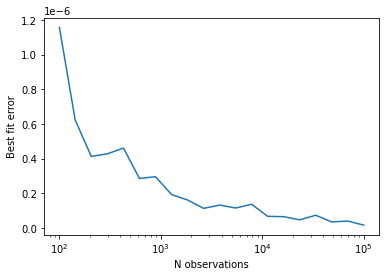

In [138]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = simulate_muon_lifetime(s)
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential, guess=2e-6)
    exp_probs.append(exp_dict["tau"][1])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit error')

Another goodness of fit statistic is the value `chi-sq`/`NDF`, the value of the chi-square test statistic over the number of degrees of freedom.  Plot this as a function of the data points (the relevant information is stored in the dictionary returned by `plot_data_and_fit`).  Does it change much?  Why or why not?

Text(0, 0.5, 'Best fit lifetime')

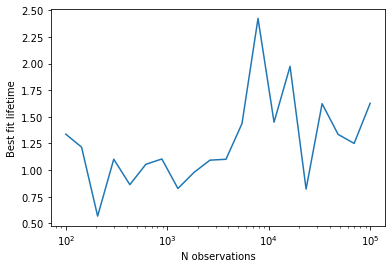

In [139]:
sizes = [int(f) for f in np.logspace(2,5,num=20)]
exp_probs = []

for s in sizes:
    local_data = simulate_muon_lifetime(s)
    exp_dict = plot_data_and_fit(local_data, num_bins=25, doPlot=False, function=exponential, guess=2e-6)
    exp_probs.append(exp_dict["chi-sq"]/exp_dict["NDF"])
    
plt.plot(sizes, exp_probs)
plt.xscale('log')
plt.xlabel('N observations')
plt.ylabel('Best fit chi-sq/NDF')